# Efficiency
## We cannot go above a specific memory usage (same as below?)
The amount of ads in the table is given by `d = xa/(a + w)`, where `x` is the number of requests constantly trying to get into the table, `a` is ad lifetime (the time spent in the table by each ad before being evicted) and `w` is the average waiting time received by the requests.

Assuming the worst case scenario, when the attacker is able to achieve 0 similarity score for both the topic and the IP addresses, the waiting time formula gives us: `w = (ba)/(1 - d/n)^P_occupancy`

Plugging that in into the previous equation, we get `d = xa/((a + (ba)/(1 - d/n)^P_occupancy)) = x/((1 + b/(1 - d/n)^P_occupancy))`.


Assuming an average size of an advertisement equal to 1KB we have `x ~= registrar_download_link_in_B / 1024`. 

In consultation with the Geth developers, we set up the capacity of the table to `n = 1000`. 

This gives us `d = (registrar_download_link_in_B / 1024)/((1 + b/(1 - d/1000)^P_occupancy))`

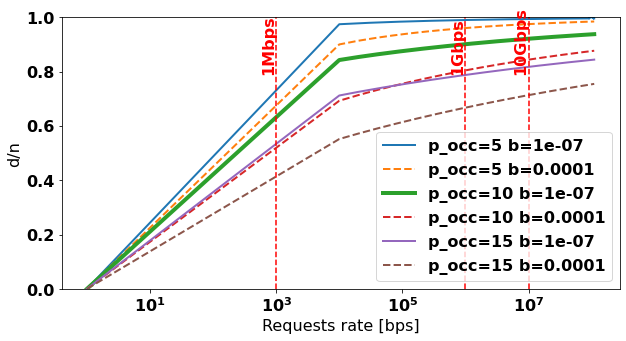

In [13]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Define the expression whose roots we want to find
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
n = 1000

for p_occupancy in [5, 10, 15]:
    for b in [0.0000001, 0.0001]:
        x_vals = []
        y_vals = []

        for x in range(1, 110000000, 10000):
            func = lambda d: x/(1+ b/(1-(d)/n)**p_occupancy) - (d)
            d = np.linspace(0, 300, 300)

            # Use the numerical solver to find the roots
            d_initial_guess = 10
            d_solution = fsolve(func, d_initial_guess)

            x_vals.append(x)
            y_vals.append(d_solution/n)
        if(b == 0.0001):
            ax.plot(x_vals, y_vals, label='p_occ=' + str(p_occupancy) + " b=" + str(b), linestyle = "--", linewidth = 2)
        elif (p_occupancy == 10):
            ax.plot(x_vals, y_vals, label='p_occ=' + str(p_occupancy) + " b=" + str(b), linestyle = "-", linewidth = 4)
        else:
            ax.plot(x_vals, y_vals, label='p_occ=' + str(p_occupancy) + " b=" + str(b), linestyle = "-", linewidth = 2)

plt.ylabel("d/n")
plt.xlabel("Request rate [bps]")

plt.axvline(x=10000000, color='red', linestyle='--')
plt.annotate("10Gbps", xy = (10000000*0.75, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000000, color='red', linestyle='--')
plt.annotate("1Gbps", xy = (1000000*0.75, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000, color='red', linestyle='--')
plt.annotate("1Mbps", xy = (1000*0.75, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.xscale("log")
plt.ylim(0, 1)
plt.legend()
plt.show()

We want to:
* keep `d` as small as possible to prevent interference with the topic and IP scores
* use the space in the table even for low traffic
* make sure that we never go beyond 100% table capacity

As a result, we set `d = 10^-7` and `p_occupancy = 10`. For lower occupancies (e.g., `p_occupancy = 5`), it's theoretically possible to go beyond the capacity of the table. 

### TODO
@Ramin: Is it possible to calculate an asymptote the `d` goes toward based on `p_occupancy` and `b`? We could then have a much clearer graph and better motivation for the chosen values. 

## The state maintained by each registrar is bounded to `O(n)`
* We proved above that the size of the topic cash is limited with the right set of parameters
* The request received by each registrar do not create any state (apart from the lower bound) at the registrar (i.e., the registrar uniquely calculates the waiting time and return a signed ticket)
* The lower bound state create by registrars is bounded by the number of distinct IPs and topic in the cash and is thus bounded `O(n)`


## Both register and lookup operations finish within O(log(n)) steps
They both mimic MSG_FIND from regular DHT operations and thus inherits this property. 

### TODO
make sure we distinguish between `n` - number of nodes in the network and `n` - capacity of the ad cash.


# Fairness

## Register operations introduce an equal load on the registrars even with unequal popularity of the topics.

We assume a Zipf distribution of the topics in the system and that the topic hashes are uniformly distributed in the hash space. For simplicity we uniquely compare the load of `registrar A` - located close to the most popular `topic A` and the load of `registrar B` - located close to the least popular `topic B`. There are `n` nodes in the network, `topic A` is followed by `n_a` nodes and `topic B` is followed by `n_b` nodes, where `n_a >> n_b`. 

Let us assume that `topic A` and `topic B` are located on the oposite part of the hashspace (the worst case scenario for load balancing) and that both `registrar A` and `registrar B` receive the same amount of traffic `L_X` from other topic `topic X != topic A and  topic X != topic B`. 

`registrar A` will receive registration requests from `B_A = n_a/max(1, n/2^17) ~= n_a` (for any reasonable size of `n`) nodes for `topic A` and `B_B = (n_b*K_register)/(n/2)` request for `topic B`. That gives us the total load on `registrar_A` equal to `L_A = L_X + n_a + (n_b*K_register)/(n/2)`. 

Similarely, the total load on `registrar_B` is equal to `L_B = L_X + n_b + (n_a*K_register)/(n/2)`. 

ratio: 1 N_A: 7500.0 N_B: 7500.0
ratio: 2 N_A: 5000.0 N_B: 10000.0
ratio: 3 N_A: 3750.0 N_B: 11250.0
ratio: 4 N_A: 3000.0 N_B: 12000.0
ratio: 5 N_A: 2500.0 N_B: 12500.0
ratio: 6 N_A: 2142.8571428571427 N_B: 12857.142857142857
ratio: 7 N_A: 1875.0 N_B: 13125.0
ratio: 8 N_A: 1666.6666666666667 N_B: 13333.333333333334
ratio: 9 N_A: 1500.0 N_B: 13500.0
ratio: 10 N_A: 1363.6363636363637 N_B: 13636.363636363636
ratio: 11 N_A: 1250.0 N_B: 13750.0
ratio: 12 N_A: 1153.8461538461538 N_B: 13846.153846153846
ratio: 13 N_A: 1071.4285714285713 N_B: 13928.57142857143
ratio: 14 N_A: 1000.0 N_B: 14000.0
ratio: 15 N_A: 937.5 N_B: 14062.5
ratio: 16 N_A: 882.3529411764706 N_B: 14117.64705882353
ratio: 17 N_A: 833.3333333333334 N_B: 14166.666666666666
ratio: 18 N_A: 789.4736842105264 N_B: 14210.526315789473
ratio: 19 N_A: 750.0 N_B: 14250.0
ratio: 20 N_A: 714.2857142857143 N_B: 14285.714285714286
ratio: 21 N_A: 681.8181818181819 N_B: 14318.181818181818
ratio: 22 N_A: 652.1739130434783 N_B: 14347.8260869565

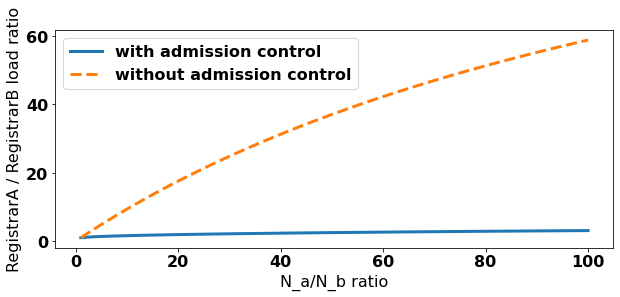

In [25]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}


matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Define the expression whose roots we want to find
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()


n = 1000             # Table capacity
p_occupancy = 10
b = 0.0000001

N = 25000            # Network size
K_register = 5       # Number of registrations per bucket
N_A = 20             # Number of advertisers for topic A (will be overwritten in the for loop below)
N_B = 500           # Number of advertisers for topic B
N_A_B = 15000
R_X = 100            # Background number of registrations

x_vals = []
y_vals_A = []
y_vals_B = []
y_vals_A_B = []
y_vals_A_B_no_function = []

# The d equations for registrar close to topic A.
# This ignores the IP score, assuming that it is 0 ("worst case" of perfectly balanced addresses)
def equations_A(dvec):
    d_a = dvec[0]
    d_b = dvec[1]
    d_x = dvec[2]
    d = d_a + d_b + d_x
    t = 1 / (1 - d/n)**p_occupancy
    # Number of registrations that this registrar will get for topic A and B
    R_A = N_A
    R_B = K_register* N_B / (N/2)
    return [ R_A / (1+(b+d_a/d)*t) - d_a , R_B / (1+(b+d_b/d)*t) - d_b , R_X / (1+(b+d_x/d)*t) - d_x ]

def equations_B(dvec):
    d_a = dvec[0]
    d_b = dvec[1]
    d_x = dvec[2]
    d = d_a + d_b + d_x
    t = 1 / (1 - d/n)**p_occupancy
    # Number of registrations that this registrar will get for topic A and B
    R_A = K_register* N_A / (N/2)
    R_B = N_B
    return [ R_A / (1+(b+d_a/d)*t) - d_a , R_B / (1+(b+d_b/d)*t) - d_b , R_X / (1+(b+d_x/d)*t) - d_x ]

for a_to_b_ratio in range(1, 101):
    # Number of advertisers for topic A
    N_A = N_A_B / (1+a_to_b_ratio)
    N_B = N_A_B - N_A
    print("ratio:", a_to_b_ratio, "N_A:", N_A, "N_B:", N_B)
    #N_A = a_to_b_ratio * N_B


    x_vals.append(a_to_b_ratio)
    
    # This seems to be very sensitive to the initial guess!
    
    dvec_solutionA = fsolve(equations_A, [100,100,50])
    d_solutionA = dvec_solutionA[0]+dvec_solutionA[1]+dvec_solutionA[2]
    y_vals_A.append(d_solutionA/n)
    
    dvec_solutionB = fsolve(equations_B, [100,300,50])
    d_solutionB = dvec_solutionB[0]+dvec_solutionB[1]+dvec_solutionB[2]
    y_vals_B.append(d_solutionB/n)
    #print("A: ",N_A,dvec_solutionA, "   B: ",N_B,dvec_solutionB)

    y_vals_A_B.append(d_solutionB/d_solutionA)

    traffic_A =  N_A + (N_B * K_register) / (N/2) + R_X
    traffic_B =  N_B + (N_A * K_register) / (N/2) + R_X
    y_vals_A_B_no_function.append(traffic_B/traffic_A)
    
#ax.plot(x_vals, y_vals_A, label="node A")
#ax.plot(x_vals, y_vals_B, label="node B")
ax.plot(x_vals, y_vals_A_B, label="with admission control", linewidth = 3, linestyle = "-")
ax.plot(x_vals, y_vals_A_B_no_function, label="without admission control", linewidth = 3, linestyle = "--")

plt.ylabel("RegistrarA / RegistrarB load ratio")
plt.xlabel("N_a/N_b ratio")#, p_occupancy=" + str(p_occupancy) + ", b=" + str(b))

#plt.ylim(0, 1)
plt.legend()
plt.show()

## Lookup operations introduce an equal load on the registrars even with unequal popularity of the topics.
We're interested in the number of lookups both registrars receive. We ignore the background traffic, as it should be the same for both registrars. 

The amount of traffic is given by the number of searchers for both topics `n_a` and `n_b` and their probability of reaching the last bucket `P_reach_a` and `P_reach_b`. 

To calculate `P_reach_a`, we need:
* The distribution of the number of ads for given topic on registrars in each bucket `d_a_i`. We can get the average number of ads, but what kind of distribution can we assume here (is normal a good guess - can we justify it)?
* Once having the distribution (per bucket)

Useful resources:
* https://mathworld.wolfram.com/UniformSumDistribution.html
* This seems as exactly something we need (assuming normal distribution) - https://math.stackexchange.com/questions/3544099/how-many-normal-distribution-random-numbers-sum-exceeds-r






/home/harnen/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/harnen/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Probability to have less than 30 responses after 7 = 1.0
The load on the last node is 1.0
Probability to have less than 30 responses after 7 = 1.0
The load on the last node is 21.0
Probability to have less than 30 responses after 7 = 1.0
The load on the last node is 41.0
Probability to have less than 30 responses after 7 = 1.0000000000000002
The load on the last node is 61.000000000000014
Probability to have less than 30 responses after 7 = 0.9999999999999999
The load on the last node is 80.99999999999999
Probability to have less than 30 responses after 7 = 1.0000000000000002
The load on the last node is 101.00000000000003
Probability to have less than 30 responses after 7 = 0.9999999999999999
The load on the last node is 120.99999999999999
Probability to have less than 30 responses after 7 = 0.9999999999999996
The load on the last node is 140.99999999999994
Probability to have less than 30 responses after 7 = 1.0000000000000002
The load on the last node is 161.00000000000003
Probabili

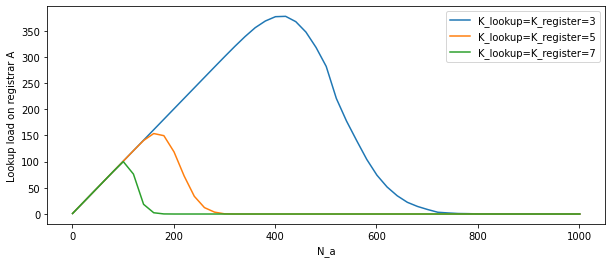

In [1]:
import scipy.special
import random
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

n = 1000             # Table capacity
p_occupancy = 10
b = 0.0000001

N = 25000
K_register = 4
N_return = 10        # Maximum number of results returned by a registrar
K_lookup = 4         # Number of lookups per bucket
N_A = 1000
R_B = 100
R_X = 500            # Background number of registrations

num_runs = 100000    # Number of simulation runs

def number_unique(num_lookups):
    num_advertisers = N_A
    #num_unique = 0
    #for i in range(0,N_return):
        # https://stats.stackexchange.com/questions/296005/the-expected-number-of-unique-elements-drawn-with-replacement
        #num_unique += num_advertisers * (1 - ( (num_advertisers-1)/num_advertisers ) ** num_lookups)
        #num_advertisers -= 1
    num_unique = num_advertisers * (1 - ( (num_advertisers-1)/num_advertisers ) ** (num_lookups*N_return))
    return num_unique
    

# Gives the probability that a registrar will be chosen by an advertiser in bucket "bucket"
def p_reg_single(bucket):
    return max(1,min(K_register, N/2**bucket)) / max(1,N/2**bucket)

# probability that a registrar will be chosen by exactly "r" advertisers (out of "advertisers" advertisers) in bucket "bucket"
def p_reg(advertisers, r, bucket):
    return scipy.special.binom(advertisers,r) * p_reg_single(bucket)**r * (1-p_reg_single(bucket))**(advertisers-r)

# The d equations for registrar close to topic A.
# This ignores the IP score, assuming that it is 0 ("worst case" of perfectly balanced addresses)
def equations_A(dvec, R_A):
    d_a = dvec[0]
    d_b = dvec[1]
    d_x = dvec[2]
    d = d_a + d_b + d_x
    t = 1 / (1 - d/n)**p_occupancy
    return [ R_A / (1+(b+d_a/d)*t) - d_a , R_B / (1+(b+d_b/d)*t) - d_b , R_X / (1+(b+d_x/d)*t) - d_x ]

# Calculates the distribution of the number of ads that a registrar in bucket "bucket"
# will return, assuming "N_A" advertisers for that topic.
# The result is an array where entry i is the probability that [i,i+1[ ads are returned.
def response_distr_node(bucket):
    num_lookups = max(1,min(K_lookup, N/2**bucket))
    unique_factor = number_unique(num_lookups) / (num_lookups*N_return)
    distr = [0] * (N_return+1)
    for r in range(0,N_A+1):
        prob = p_reg(N_A, r, bucket)
        if prob>0:
            dvec = fsolve(equations_A, [100,200,50], args=[ r ])
            ads = dvec[0]
            if ads>N_return:     # Truncate the number of ads returned
                ads = N_return
            distr[int(ads* unique_factor)] += prob
    return distr

# Samples a random value from a discrete distribution ("distr" is a histogram)
def sample_distr(distr):
    rnd = random.uniform(0, 1)
    i = 0
    while rnd>=0 and i<len(distr):
        rnd -= distr[i]
        i += 1
    return i-1

def response_distr_bucket(bucket):    
    distr = [0] * (N_return*K_lookup+1)
    distr_node = response_distr_node(bucket)
    for i in range(0,10000):
        ads = 0
        for j in range(0,K_lookup):
            ads += sample_distr(distr_node) 
        distr[ads] += 1
    for i in range(0,len(distr)):
        distr[i] /= 10000
    return distr

def response_distr(num_buckets):
    distr = [0] * (N_return*K_lookup*num_buckets+1) 
    distr_node = [0]*num_buckets
    for i in range(0,num_buckets):
       distr_node[i] = response_distr_node(i+1)
    for i in range(0,num_runs):
        ads = 0
        for k in range(0,num_buckets):
            num_lookups = int(max(1,min(K_lookup, N/2**k)))
            for j in range(0,num_lookups):
                ads += sample_distr(distr_node[k])
        distr[ads] += 1    
    for i in range(0,len(distr)):
        distr[i] /= num_runs
    return distr
        
num_buckets = 7

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()


max_i = 1002
step = 20

for K in [3, 5, 7]:
    x_vals = []
    y_vals = []
    K_lookup = K
    K_register = K
    for i in range(1, max_i, step):
        N_A = i
        distr = response_distr(num_buckets)
    #ax.plot([*range(0,len(distr))], distr, label="number of ads received for topic A after "+str(num_buckets)+" buckets", linewidth = 3, linestyle = "-")

    # calculate probability to have less than 30 responses:
        p30 = 0
        for i in range(0,30):
            p30 += distr[i]
        print("Probability to have less than 30 responses after "+str(num_buckets)+" = "+str(p30)) 
        print("The load on the last node is", p30 * N_A)

        x_vals.append(N_A)
        y_vals.append(p30 * N_A)


    ax.plot(x_vals, y_vals, label="K_lookup=K_register=" + str(K))

plt.ylabel("Lookup load on registrar A")
plt.xlabel("N_a")
plt.legend()
plt.show()


# Security

## [Without poisoning] Probability probability of a lookup operation being eclipsed

We need: 
* probability of receiving uniquely malicious ads from an honest registrar in bucket `i`: `P_h_eclipse_i`
* probability of encountering a malicious node in a specific bucket (e.g., it's gonna be `n_malicious/n` for the uniform distribution of the malicious nodes) `P_a_i` (`P_h_i = 1 - P_a_i`)

With this, we can calculate the probability of receiving uniquely malicious ads from a random node in bucket `i`. This is given by `P_random_eclipse_i = P_a_i + P_h_i * P_h_eclipse_i`

The probability of being eclipsed in a bucket after asking `K_lookup` registrars is given by: `P_eclipse_i = P_random_eclipse_i ^ K_lookup`

Finally, the probability of being entirely eclipsed is given by: `P_eclipse = sum_i:0-17(P_eclipse_i)`


To calculate `P_h_eclipse_i` we require:
* The number of honest advertiser per honest registrars in bucket `i`, `n_honest_i` - this is given by `min(n_honest, (n_honest*K_register)/(n/2^i))`
* The number of malcious advertiser per honest registrars in bucket `i`,  `n_malicious_i` - this is given by `min(n_malicious, (n_malicious*K_register)/(n/2^i))`, we can set the K_register to higher values
* The number of IP addresses that the malicious users have `n_malicious_ip_i`
* The number of ads in the table unrelated to the topic `d_x_i` - cab it be fixed for simplicity?

/home/harnen/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


n_honest: 2000
x_vals: [0.1, 0.15000000000000002, 0.20000000000000004, 0.25000000000000006, 0.30000000000000004, 0.3500000000000001, 0.40000000000000013, 0.45000000000000007, 0.5000000000000001, 0.5500000000000002, 0.6000000000000002, 0.6500000000000001, 0.7000000000000002, 0.7500000000000002, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000004, 1.0500000000000003, 1.1000000000000005, 1.1500000000000004, 1.2000000000000004, 1.2500000000000004, 1.3000000000000005, 1.3500000000000005, 1.4000000000000006, 1.4500000000000006, 1.5000000000000004, 1.5500000000000005, 1.6000000000000005, 1.6500000000000006, 1.7000000000000006, 1.7500000000000007, 1.8000000000000007, 1.8500000000000008, 1.9000000000000008, 1.9500000000000006, 2.0000000000000004, 2.0500000000000007, 2.100000000000001, 2.150000000000001, 2.2000000000000006, 2.250000000000001, 2.3000000000000007, 2.350000000000001, 2.400000000000001, 2.450000000000001, 2.500000000000001, 2.5500000000

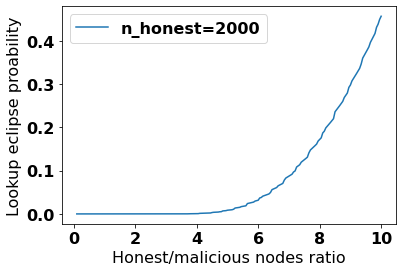

In [152]:
#!/usr/bin/python

## The code below is currently not working

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.special
import math

#constants
P_occ = 10
basescore = 1e-7
tablecapa = 1000

g_x_h = None #the number of honest registrants
g_x_a = None #the number of malicious registrants
g_ip_num_a = None #the number of distinct IPs at attacker disposal
g_others = None #the number of other requests in the table


def p(m,b):
    b = int(b)
    result = 0
    for i in range(b,int(m)+1):
        result += scipy.special.comb(m,i) / 2**m
    result += 1
    for i in range(0, b):
        result -= scipy.special.comb(m,i) / 2**m
    return result/2  

def ip_score_h(d_h, d_a, ip_num_a):
    n = d_h
    k = d_a/ip_num_a
    a = int(math.log(ip_num_a, 2))

    result = 0
    total = n+2**a*k
    for i in range (1,a+1):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-2**(a-i)*k)
    for i in range(a+1, 33):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += 1/2**(i-a) * p(m, b-k)
        result += (1-1/2**(i-a)) * p(m, b)
    return result/32


def ip_score_a(d_h, d_a, ip_num_a):
    n = d_h
    k = d_a/ip_num_a
    a = int(math.log(ip_num_a, 2))

    result = 0
    total = n+2**a*k
    for i in range (1,a+1):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-2**(a-i)*k)
    for i in range(a+1, 33):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-k)
    return result/32

def func(var):
    d_a = var[0] #attacker in the table
    d_h = var[1] #honest in the table
    d_topic = d_a+d_h
    d_all = d_a + d_h + g_others
    f = np.zeros(2)
    if d_a<g_ip_num_a:
        ipscore_att = ip_score_h(d_h, d_a, g_ip_num_a)
    else:
        ipscore_att = ip_score_a(d_h, d_a, g_ip_num_a)
    f[0] = g_x_a / (1 + (basescore + d_topic/d_all + ipscore_att)/(1-d_topic/tablecapa)**P_occ) - d_a
    f[1] = g_x_h / (1 + (basescore + d_topic/d_all + ip_score_h(d_h, d_a, g_ip_num_a))/(1-d_topic/tablecapa)**P_occ) - d_h
    return f

#the probability of being eclipsed when asking a single honest registrar
def single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup):
    global g_x_h, g_x_a, g_others, g_ip_num_a
    g_x_h = x_h #the number of honest advertisers sending registrations to this registrar
    g_x_a = x_a #the number of malicious advertisers sending registrations this registrar
    g_others = others #the number of other requests in the table
    g_ip_num_a = ip_num_a #the number of distinct IP addresses at attacker's disposal

    d_initial_guess = [g_x_a/2, g_x_h/2]
    d_solution = fsolve(func, d_initial_guess)
    d_a = int(d_solution[0]) # num of malicious ads in the table
    d_h = int(d_solution[1]) # num of honest ads in the table
    
    #print("d_a = ",d_a, ", d_h = ", d_h)

    #each searcher asks for n_lookup peer nodes from the table
    #this is similar to drawing cards without returning
    #see https://study.com/skill/learn/calculating-probabilities-of-draws-without-replacement-explanation.html
    P_eclipsed = 1
    for i in range(0, min(d_a+d_h, n_lookup)):
        P_eclipsed *= (d_a - i) / (d_a + d_h - i)
    return P_eclipsed
    
#i - the bucket number
#n - the number of all the nodes in the network
#n_honest - the number of honest advertisers in the network
#K_register - the number of registrations each honest advertisers performs per bucket
#n_malicious - the number of malicious advertisers in the network
#K_register_malicious - the number of registrations each malicious advertisers performs per bucket
#others - the number of other requests in the table (we assume it's the same for all the registrars)
#n_malicious_ip - the number of distinct IP addresses available global for malicious nodes
#n_lookup - searchers asks for n_lookup peer nodes from the cache
def P_h_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup):
    x_h = n_honest * min(1, K_register/(num_nodes/(2**bucket)))
    x_a = n_malicious * min(1, K_register_malicious/(num_nodes/(2**bucket)))
    if(int(x_a) == 0):
        return 0
    
    ip_num_a = max(1, int(n_malicious_ip*x_a /n_malicious)) #the malicious advertisers in question receive a proportional number of IP addresses
    prob = single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup)
    #print("P_h_eclipse =", prob, " x_a =", x_a, " x_h =", x_h)
    return prob

#the probability of being eclipsed in a specific bucket
def P_eclipse_i(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup, K_lookup):
    P_a_i  = n_malicious / num_nodes
    P_h_i = 1 - P_a_i
    P_random_eclipse_i = P_a_i + P_h_i * P_h_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup)
    return P_random_eclipse_i ** K_lookup


def P_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, others, n_malicious_ip, n_lookup, K_lookup):
    result = 1
    for bucket in range(1, 5):
        #print("Bucket",bucket)
        prob = P_eclipse_i(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup, K_lookup)
        #print("P_eclipse for this bucket =", prob)
        result *= prob
    return result

fig = plt.figure()
ax = fig.add_subplot()
x_vals = []
y_vals = []

num_nodes = 25000 #the number of all the nodes in the network
n_malicious = 5000
n_honest = 2000 # num_nodes - n_malicious
K_register = 5
K_register_malicious = 15
others = 0
n_malicious_ip = 1000
n_lookup = 10
K_lookup = 5


for attackers_per_ip in [0.1]:
    for malicious_to_honest_ratio in np.arange(0.1, 10.05, 0.05):
    #for i in range(0, 5000, 100):
        n_malicious = n_honest * malicious_to_honest_ratio
        #n_malicious = i
        n_malicious_ip = 1#n_malicious*attackers_per_ip
        if((n_honest + n_malicious) > num_nodes):
            break
        y_val = P_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, others, n_malicious_ip, n_lookup, K_lookup)

        #print("Eclipse probability for", n_malicious, "malicious nodes is", y_val)
        x_vals.append(malicious_to_honest_ratio)
        #x_vals.append(i)
        y_vals.append(y_val)

    ax.plot(x_vals, y_vals, label="n_honest="+str(n_honest))
    print("n_honest:", n_honest)
    print("x_vals:", x_vals)
    print("y_vals:", y_vals)

plt.ylabel("Lookup eclipse proability")
plt.xlabel("Honest/malicious nodes ratio")

#plt.ylim(0, 1)
plt.legend()
plt.show()

# With poisoning: Probability probability of a lookup operation being eclipsed

n_honest: 2000
x_vals: [0.1, 0.35, 0.6, 0.8499999999999999, 1.0999999999999999, 1.3499999999999999, 1.5999999999999999, 1.8499999999999999, 2.0999999999999996, 2.3499999999999996, 2.5999999999999996, 2.8499999999999996, 3.0999999999999996, 3.3499999999999996, 3.5999999999999996, 3.8499999999999996, 4.1, 4.349999999999999, 4.599999999999999, 4.849999999999999, 5.099999999999999, 5.349999999999999, 5.599999999999999, 5.849999999999999, 6.099999999999999, 6.349999999999999, 6.599999999999999, 6.849999999999999, 7.099999999999999, 7.349999999999999, 7.599999999999999, 7.849999999999999, 8.1, 8.349999999999998, 8.599999999999998, 8.849999999999998, 9.099999999999998, 9.349999999999998, 9.599999999999998, 9.849999999999998]
y_vals: [3.92511741787735e-42, 1.1068918914852543e-23, 1.7486144736393342e-13, 4.36892981057939e-12, 6.17304824003375e-11, 1.7343748890583334e-09, 2.1248625788491506e-08, 1.7053347748547192e-07, 6.11052344285959e-07, 1.3290047933028447e-05, 9.507604744036187e-05, 0.000317

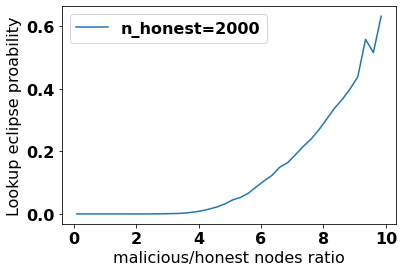

In [180]:
#!/usr/bin/python

## The code below is currently not working

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.special
import math
import random

#constants
P_occ = 10
basescore = 1e-7
tablecapa = 1000

g_x_h = None #the number of honest registrants
g_x_a = None #the number of malicious registrants
g_ip_num_a = None #the number of distinct IPs at attacker disposal
g_others = None #the number of other requests in the table


def p(m,b):
    b = int(b)
    result = 0
    for i in range(b,int(m)+1):
        result += scipy.special.comb(m,i) / 2**m
    result += 1
    for i in range(0, b):
        result -= scipy.special.comb(m,i) / 2**m
    return result/2  

def ip_score_h(d_h, d_a, ip_num_a):
    n = d_h
    k = d_a/ip_num_a
    a = int(math.log(ip_num_a, 2))

    result = 0
    total = n+2**a*k
    for i in range (1,a+1):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-2**(a-i)*k)
    for i in range(a+1, 33):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += 1/2**(i-a) * p(m, b-k)
        result += (1-1/2**(i-a)) * p(m, b)
    return result/32


def ip_score_a(d_h, d_a, ip_num_a):
    n = d_h
    k = d_a/ip_num_a
    a = int(math.log(ip_num_a, 2))

    result = 0
    total = n+2**a*k
    for i in range (1,a+1):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-2**(a-i)*k)
    for i in range(a+1, 33):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-k)
    return result/32

def func(var):
    d_a = var[0] #attacker in the table
    d_h = var[1] #honest in the table
    d_topic = d_a+d_h
    d_all = d_a + d_h + g_others
    f = np.zeros(2)
    if d_a<g_ip_num_a:
        ipscore_att = ip_score_h(d_h, d_a, g_ip_num_a)
    else:
        ipscore_att = ip_score_a(d_h, d_a, g_ip_num_a)
    f[0] = g_x_a / (1 + (basescore + d_topic/d_all + ipscore_att)/(1-d_topic/tablecapa)**P_occ) - d_a
    f[1] = g_x_h / (1 + (basescore + d_topic/d_all + ip_score_h(d_h, d_a, g_ip_num_a))/(1-d_topic/tablecapa)**P_occ) - d_h
    return f

#the probability of being eclipsed when asking a single honest registrar
def single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup):
    global g_x_h, g_x_a, g_others, g_ip_num_a
    g_x_h = x_h #the number of honest advertisers sending registrations to this registrar
    g_x_a = x_a #the number of malicious advertisers sending registrations this registrar
    g_others = others #the number of other requests in the table
    g_ip_num_a = ip_num_a #the number of distinct IP addresses at attacker's disposal

    d_initial_guess = [g_x_a/2, g_x_h/2]
    d_solution = fsolve(func, d_initial_guess)
    d_a = int(d_solution[0]) # num of malicious ads in the table
    d_h = int(d_solution[1]) # num of honest ads in the table
    
    #print("d_a = ",d_a, ", d_h = ", d_h)

    #each searcher asks for n_lookup peer nodes from the table
    #this is similar to drawing cards without returning
    #see https://study.com/skill/learn/calculating-probabilities-of-draws-without-replacement-explanation.html
    P_eclipsed = 1
    for i in range(0, min(d_a+d_h, n_lookup)):
        P_eclipsed *= (d_a - i) / (d_a + d_h - i)
    return P_eclipsed
    
#i - the bucket number
#n - the number of all the nodes in the network
#n_honest - the number of honest advertisers in the network
#K_register - the number of registrations each honest advertisers performs per bucket
#n_malicious - the number of malicious advertisers in the network
#K_register_malicious - the number of registrations each malicious advertisers performs per bucket
#others - the number of other requests in the table (we assume it's the same for all the registrars)
#n_malicious_ip - the number of distinct IP addresses available global for malicious nodes
#n_lookup - searchers asks for n_lookup peer nodes from the cache
def P_h_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup):
    x_h = n_honest * min(1, K_register/(num_nodes/(2**bucket)))
    x_a = n_malicious * min(1, K_register_malicious/(num_nodes/(2**bucket)))
    if(int(x_a) == 0):
        return 0
    
    ip_num_a = max(1, int(n_malicious_ip*x_a /n_malicious)) #the malicious advertisers in question receive a proportional number of IP addresses
    prob = single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup)
    #print("P_h_eclipse =", prob, " x_a =", x_a, " x_h =", x_h)
    return prob

#the probability of being eclipsed in a specific bucket
def P_eclipse_i(ratio_malicious, num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup, K_lookup):
    P_a_i  = ratio_malicious
    P_h_i = 1 - P_a_i
    P_random_eclipse_i = P_a_i + P_h_i * P_h_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup)
    return P_random_eclipse_i ** K_lookup


# num_known_per_bucket = [K_register,K_register,K_register,4,2,1,0] # number of nodes per bucket the searcher already knows
# num_malicious_responses = 4  # number of next buckets for which responses are obtained from a malicious node
# num_honest_responses = 4  # number of next buckets for which responses are obtained from a honest node
#
# returns ratio of malicious nodes in each bucket
def Calculate_Poisoning(attdensity, num_runs, num_buckets,num_known_per_bucket,num_malicious_responses,num_honest_responses,K_register):
    sum_attbuckets = [0]*num_buckets
    for i in range(num_runs):
        # initialize empty buckets
        attbuckets = [0]*num_buckets
        honestbuckets = [0]*num_buckets
        # initialize buckets
        for j in range(num_buckets):
            for k in range(num_known_per_bucket[j]):
                if random.random()<=attdensity:
                    attbuckets[j] = attbuckets[j]+1
            honestbuckets[j] = num_known_per_bucket[j]-attbuckets[j]
        # simulate progression through buckets
        for j in range(num_buckets-1):
            # We ask the attbuckets[j] and honestbuckets[j] nodes in this bucket j in random order:
            indexes = list(range(0, K_register))
            random.shuffle(indexes)
            for z in indexes:
                if z<attbuckets[j]:
                    # We asked a malicious node
                    # Malicious nodes will send responses for all buckets:
                    for k in range(j+1,min(j+1+num_malicious_responses,num_buckets)):
                        attbuckets[k] = min(attbuckets[k]+1, K_register-honestbuckets[k])
                else:
                    # We asked a honest node
                    # Honest nodes will only send response for a few next buckets
                    for k in range(j+1,min(j+1+num_honest_responses,num_buckets)):
                        # honest node will also sometimes return malicious nodes
                        if random.random()<=attdensity:
                            attbuckets[k] = min(attbuckets[k]+1, K_register-honestbuckets[k])
                        else:
                            honestbuckets[k] = min(honestbuckets[k]+1, K_register-attbuckets[k])
        # sum up result
        for j in range(num_buckets):
            sum_attbuckets[j] = sum_attbuckets[j]+attbuckets[j]

    return [ x/num_runs/K_register for x in sum_attbuckets ]


def P_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, others, n_malicious_ip, n_lookup, K_lookup):
    num_buckets = 5
    attdensity = n_malicious/num_nodes
    
    poisoning_ratio = Calculate_Poisoning(attdensity, 20000, num_buckets+1, [K_register,K_register,K_register,4,2,1,0], 4, 4, K_register)
    #print(poisoning_ratio)
    
    attack_func = lambda bucket : poisoning_ratio[bucket-1]
    
    result = 1
    for bucket in range(1, num_buckets):
        #print("Bucket",bucket)
        prob = P_eclipse_i(attack_func(bucket), num_nodes, n_honest, K_register, n_malicious, K_register_malicious, bucket, others, n_malicious_ip, n_lookup, K_lookup)
        #print("P_eclipse for this bucket =", prob)
        result *= prob
    return result

fig = plt.figure()
ax = fig.add_subplot()
x_vals = []
y_vals = []

num_nodes = 25000 #the number of all the nodes in the network
n_malicious = 5000
n_honest = 2000 # num_nodes - n_malicious
K_register = 5
K_register_malicious = 15
others = 0
n_malicious_ip = 1000
n_lookup = 10
K_lookup = 5

for attackers_per_ip in [0.1]:
    for malicious_to_honest_ratio in np.arange(0.1, 10.05, 0.25):
    #for i in range(0, 5000, 100):
        n_malicious = n_honest * malicious_to_honest_ratio
        #n_malicious = i
        n_malicious_ip = n_malicious #n_malicious*attackers_per_ip
        if((n_honest + n_malicious) > num_nodes):
            break
        
        y_val = P_eclipse(num_nodes, n_honest, K_register, n_malicious, K_register_malicious, others, n_malicious_ip, n_lookup, K_lookup)

        #print("Eclipse probability for", n_malicious, "malicious nodes is", y_val)
        x_vals.append(malicious_to_honest_ratio)
        #x_vals.append(i)
        y_vals.append(y_val)

    ax.plot(x_vals, y_vals, label="n_honest="+str(n_honest))
    print("n_honest:", n_honest)
    print("x_vals:", x_vals)
    print("y_vals:", y_vals)

plt.ylabel("Lookup eclipse proability")
plt.xlabel("malicious/honest nodes ratio")

#plt.ylim(0, 1)
plt.legend()
plt.show()

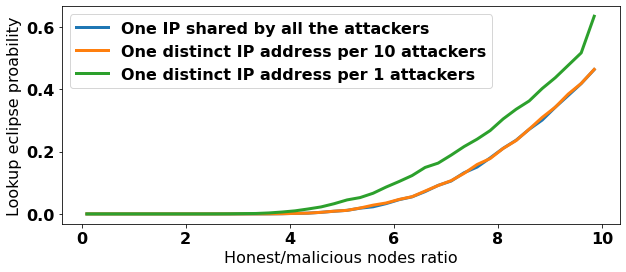

In [181]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}


matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42




#x_vals_001 = [0.1, 0.15000000000000002, 0.20000000000000004, 0.25000000000000006, 0.30000000000000004, 0.3500000000000001, 0.40000000000000013, 0.45000000000000007, 0.5000000000000001, 0.5500000000000002, 0.6000000000000002, 0.6500000000000001, 0.7000000000000002, 0.7500000000000002, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000004, 1.0500000000000003, 1.1000000000000005, 1.1500000000000004, 1.2000000000000004, 1.2500000000000004, 1.3000000000000005, 1.3500000000000005, 1.4000000000000006, 1.4500000000000006, 1.5000000000000004, 1.5500000000000005, 1.6000000000000005, 1.6500000000000006, 1.7000000000000006, 1.7500000000000007, 1.8000000000000007, 1.8500000000000008, 1.9000000000000008, 1.9500000000000006, 2.0000000000000004, 2.0500000000000007, 2.100000000000001, 2.150000000000001, 2.2000000000000006, 2.250000000000001, 2.3000000000000007, 2.350000000000001, 2.400000000000001, 2.450000000000001, 2.500000000000001, 2.5500000000000007, 2.600000000000001, 2.650000000000001, 2.700000000000001, 2.750000000000001, 2.800000000000001, 2.850000000000001, 2.900000000000001, 2.950000000000001, 3.000000000000001, 3.050000000000001, 3.100000000000001, 3.1500000000000012, 3.200000000000001, 3.2500000000000013, 3.300000000000001, 3.350000000000001, 3.4000000000000012, 3.450000000000001, 3.5000000000000013, 3.550000000000001, 3.6000000000000014, 3.6500000000000012, 3.7000000000000015, 3.7500000000000013, 3.800000000000001, 3.8500000000000014, 3.9000000000000012, 3.9500000000000015, 4.000000000000001, 4.050000000000002, 4.100000000000001, 4.150000000000001, 4.200000000000001, 4.250000000000001, 4.300000000000001, 4.350000000000001, 4.400000000000001, 4.450000000000001, 4.500000000000001, 4.550000000000001, 4.600000000000001, 4.650000000000001, 4.700000000000001, 4.750000000000001, 4.800000000000002, 4.850000000000001, 4.900000000000001, 4.950000000000001, 5.000000000000001, 5.050000000000002, 5.100000000000001, 5.150000000000001, 5.200000000000001, 5.250000000000002, 5.300000000000002, 5.350000000000001, 5.400000000000001, 5.450000000000001, 5.500000000000002, 5.550000000000002, 5.600000000000001, 5.650000000000001, 5.700000000000001, 5.750000000000002, 5.800000000000002, 5.850000000000001, 5.900000000000001, 5.950000000000002, 6.000000000000002, 6.050000000000002, 6.100000000000001, 6.150000000000001, 6.200000000000002, 6.250000000000002, 6.300000000000002, 6.350000000000001, 6.400000000000002, 6.450000000000002, 6.500000000000002, 6.550000000000002, 6.600000000000001, 6.650000000000002, 6.700000000000002, 6.750000000000002, 6.800000000000002, 6.850000000000002, 6.900000000000002, 6.950000000000002, 7.000000000000002, 7.050000000000002, 7.100000000000002, 7.150000000000002, 7.200000000000002, 7.250000000000002, 7.3000000000000025, 7.350000000000002, 7.400000000000002, 7.450000000000002, 7.500000000000002, 7.5500000000000025, 7.600000000000002, 7.650000000000002, 7.700000000000002, 7.750000000000002, 7.8000000000000025, 7.850000000000002, 7.900000000000002, 7.950000000000002, 8.000000000000004, 8.050000000000002, 8.100000000000003, 8.150000000000002, 8.200000000000003, 8.250000000000002, 8.300000000000002, 8.350000000000003, 8.400000000000002, 8.450000000000003, 8.500000000000002, 8.550000000000002, 8.600000000000003, 8.650000000000002, 8.700000000000003, 8.750000000000002, 8.800000000000002, 8.850000000000003, 8.900000000000002, 8.950000000000003, 9.000000000000002, 9.050000000000002, 9.100000000000003, 9.150000000000002, 9.200000000000003, 9.250000000000004, 9.300000000000002, 9.350000000000003, 9.400000000000002, 9.450000000000003, 9.500000000000004, 9.550000000000002, 9.600000000000003, 9.650000000000002, 9.700000000000003, 9.750000000000004, 9.800000000000002, 9.850000000000003, 9.900000000000002, 9.950000000000003, 10.000000000000004]
#y_vals_001 =  [1.1529215046068473e-42, 3.833759992447486e-39, 1.2089258196146353e-36, 3.2768000000000095e-26, 5.0485728295604715e-25, 5.097655355238413e-24, 3.777893186295731e-23, 3.6561584400629804e-15, 1.048576000000002e-14, 2.719736093841825e-14, 6.492506210854523e-14, 1.4455510594905733e-13, 3.0330548909611503e-13, 6.04661760000002e-13, 1.15292150460685e-12, 2.1139228201572165e-12, 3.743906242624498e-12, 6.4288889323399644e-12, 1.0737418240000059e-11, 1.749012287659813e-11, 2.785009760094033e-11, 4.34388454223634e-11, 6.648326359915031e-11, 1.0000000000000033e-10, 1.4802442849183492e-10, 2.1589249972727947e-10, 3.105848208344225e-10, 4.411435078649939e-10, 6.19173642240002e-10, 8.594425506491831e-10, 1.1805916207174143e-09, 1.605976966052662e-09, 3.427286073952376e-09, 4.5136446980437245e-09, 5.900537296332374e-09, 7.659695107739303e-09, 1.7400326070502134e-08, 2.196527536224007e-08, 2.7579297212713462e-08, 3.445112282100149e-08, 7.356634852742947e-08, 8.992461304286781e-08, 1.0947444925663343e-07, 1.3275582351942251e-07, 2.5895616908953944e-07, 3.088505018860586e-07, 3.6718346012975066e-07, 6.628325773636615e-07, 7.776000000000026e-07, 9.09796609825843e-07, 1.0617164644914713e-06, 1.771361578925206e-06, 2.045489519783357e-06, 2.356805903484662e-06, 2.709680352066589e-06, 4.231158749622817e-06, 4.823441867370302e-06, 5.488353602201611e-06, 6.233601312219332e-06, 9.211385860959728e-06, 1.0389075467438368e-05, 1.1698567468643382e-05, 1.3152615832051719e-05, 1.8562064731446504e-05, 2.07469954689658e-05, 2.3156891229110138e-05, 7.668746679621677e-05, 0.00010212439337587293, 0.0001111305786710041, 0.00012084003220763096, 0.00013130078507421367, 0.00016957319509124512, 0.00018361938289905019, 0.00039245856642232543, 0.0004202130826277687, 0.00044971610568744075, 0.0005591889606526414, 0.0005968846620175419, 0.0006368422585254346, 0.0006791810771646946, 0.00131879607764058, 0.0013948676623472406, 0.0014748579541663585, 0.0015589450135826191, 0.001852500306744437, 0.001954449878635418, 0.0020614073934772208, 0.0021735897254988854, 0.0032025212384386506, 0.0037268949433936407, 0.0039067568895253795, 0.004094383241282227, 0.004290070123504613, 0.004927077550087219, 0.005155347715606908, 0.006941510819142484, 0.007239486012093511, 0.007548917810632501, 0.008537458796929851, 0.008891721661646054, 0.00925914777633871, 0.00964016971193517, 0.01079478674888487, 0.013619949895282228, 0.014132845976686518, 0.014663053260041909, 0.015211088973040462, 0.01683520397783004, 0.017447932222096035, 0.01808064461265237, 0.01873391802852283, 0.023927995173169292, 0.024730452751438755, 0.025557042862517167, 0.026408408282497704, 0.027285206714009892, 0.029697710917656057, 0.030660278174231243, 0.03165081917518519, 0.03682125091021129, 0.037953361872703845, 0.040984286880540566, 0.04221556493165104, 0.04348002793257777, 0.0447784683519854, 0.046111695164626994, 0.049504297921006725, 0.05607170744293431, 0.05763850818625057, 0.059244599662851276, 0.06089085520883782, 0.06496181393345256, 0.06672915515378364, 0.06853964554931113, 0.07039421885394753, 0.07811441972545072, 0.08287538064324754, 0.08499198821905234, 0.08715712145699066, 0.08937176669748279, 0.09163692777820473, 0.0968166736374835, 0.09922321970949767, 0.10828412789230021, 0.11087901705548563, 0.11352973745451171, 0.11940603543376968, 0.12220728672739113, 0.12506754297466469, 0.12798790633124715, 0.13096949692405369, 0.14105991970099516, 0.14770964310984433, 0.150984759778054, 0.15432508833109598, 0.15773178040665028, 0.16120600539887348, 0.1682905711524306, 0.17193320509186288, 0.17564664397908183, 0.18698609541458489, 0.1909014096292518, 0.1986275895465958, 0.2027167131658256, 0.20688144546053108, 0.21112302657019721, 0.21544271439620585, 0.21984178481944405, 0.2358810419008727, 0.24050318933185136, 0.245206691629026, 0.24999281912928545, 0.2548628594920826, 0.25981811790150733, 0.2687569013562179, 0.2739004388118649, 0.27913240178391585, 0.29217219685228857, 0.29760521287792974, 0.3070735381562876, 0.31269650651039455, 0.3184119731258416, 0.32422128806123157, 0.33012581858532375, 0.33612694936473964, 0.34608087129195575, 0.3598036124053968, 0.36609864229812017, 0.37249261733114036, 0.3789869174499229, 0.38558293940971916, 0.39607764369129933, 0.40287252409435914, 0.4097721362092057, 0.4167779124735378, 0.43090615001629134, 0.43810088455340457, 0.44906938237105526, 0.4564628728254286]

x_vals_01  =[0.1, 0.35, 0.6, 0.8499999999999999, 1.0999999999999999, 1.3499999999999999, 1.5999999999999999, 1.8499999999999999, 2.0999999999999996, 2.3499999999999996, 2.5999999999999996, 2.8499999999999996, 3.0999999999999996, 3.3499999999999996, 3.5999999999999996, 3.8499999999999996, 4.1, 4.349999999999999, 4.599999999999999, 4.849999999999999, 5.099999999999999, 5.349999999999999, 5.599999999999999, 5.849999999999999, 6.099999999999999, 6.349999999999999, 6.599999999999999, 6.849999999999999, 7.099999999999999, 7.349999999999999, 7.599999999999999, 7.849999999999999, 8.1, 8.349999999999998, 8.599999999999998, 8.849999999999998, 9.099999999999998, 9.349999999999998, 9.599999999999998, 9.849999999999998]
y_vals_01 = [2.2325060403778552e-42, 1.485505681361792e-23, 1.6621017466712678e-13, 4.725667765259608e-12, 6.136083017106141e-11, 4.586611101292722e-10, 2.639214630458861e-09, 1.611619768634796e-08, 1.284770763856755e-07, 4.989982531463422e-07, 1.7154253604731774e-06, 6.159713526926395e-06, 1.5062854947077718e-05, 0.00010114854251942366, 0.00018249181185108808, 0.000677665389701827, 0.0016574306154098562, 0.0024996495456058804, 0.005142614418804161, 0.008703514405908623, 0.011475929459050233, 0.018932415032044906, 0.02812533130136385, 0.03506188505196325, 0.04650021404543485, 0.05524930050621459, 0.07334929219962719, 0.09112315456893477, 0.10664257997276852, 0.13012789469757366, 0.15851974051814124, 0.17748753143538532, 0.21001669118616256, 0.2354700807120272, 0.27172721249976245, 0.3093866860273846, 0.3420367244812202, 0.38429123715585684, 0.41842205998578974, 0.4634916277573935]

x_vals_1 = [0.1, 0.35, 0.6, 0.8499999999999999, 1.0999999999999999, 1.3499999999999999, 1.5999999999999999, 1.8499999999999999, 2.0999999999999996, 2.3499999999999996, 2.5999999999999996, 2.8499999999999996, 3.0999999999999996, 3.3499999999999996, 3.5999999999999996, 3.8499999999999996, 4.1, 4.349999999999999, 4.599999999999999, 4.849999999999999, 5.099999999999999, 5.349999999999999, 5.599999999999999, 5.849999999999999, 6.099999999999999, 6.349999999999999, 6.599999999999999, 6.849999999999999, 7.099999999999999, 7.349999999999999, 7.599999999999999, 7.849999999999999, 8.1, 8.349999999999998, 8.599999999999998, 8.849999999999998, 9.099999999999998, 9.599999999999998, 9.849999999999998]
y_vals_1 = [1.7101983111473705e-42, 1.1439593691408822e-23, 1.6451661497053666e-13, 5.2216667273913e-12, 6.29348200708233e-11, 1.5083693575960037e-09, 2.3029390437600066e-08, 1.6183226493152032e-07, 6.125432604904932e-07, 1.3396374055507263e-05, 9.010688041500272e-05, 0.0003254588532370495, 0.0009378792089969891, 0.0014353016619259753, 0.0031433933468180564, 0.0060703437515498785, 0.009845231413310276, 0.01583651981522624, 0.022445408715228845, 0.03269231849716404, 0.04491250187915864, 0.05237819065272726, 0.06628804834514969, 0.08613409772867281, 0.10396158841723602, 0.1230352236544745, 0.14903364054997867, 0.1628842839167106, 0.18854884574881892, 0.21603637493585778, 0.23975831434571288, 0.2672654303081185, 0.30460966391609695, 0.33571998786097923, 0.36222979100811403, 0.4021030184374775, 0.43653352718170835, 0.5164010472055116, 0.6338746584359437]

a_x_vals = [0.1, 0.35, 0.6, 0.8499999999999999, 1.0999999999999999, 1.3499999999999999, 1.5999999999999999, 1.8499999999999999, 2.0999999999999996, 2.3499999999999996, 2.5999999999999996, 2.8499999999999996, 3.0999999999999996, 3.3499999999999996, 3.5999999999999996, 3.8499999999999996, 4.1, 4.349999999999999, 4.599999999999999, 4.849999999999999, 5.099999999999999, 5.349999999999999, 5.599999999999999, 5.849999999999999, 6.099999999999999, 6.349999999999999, 6.599999999999999, 6.849999999999999, 7.099999999999999, 7.349999999999999, 7.599999999999999, 7.849999999999999, 8.1, 8.349999999999998, 8.599999999999998, 8.849999999999998, 9.099999999999998, 9.349999999999998, 9.599999999999998, 9.849999999999998]
a_y_vals = [2.1458959354936317e-42, 1.721980096489908e-23, 1.4835801539938967e-13, 5.1405389431298236e-12, 5.964558026414533e-11, 5.013242295975991e-10, 2.582618757786103e-09, 1.6192329601075602e-08, 1.2449137061126476e-07, 5.518660225209343e-07, 1.721208061553879e-06, 6.049470020505228e-06, 1.5919963003366535e-05, 3.296053557526179e-05, 0.00018271013945526037, 0.0005897176509929092, 0.001727543305502679, 0.0024755915588116776, 0.0050741516816380445, 0.008592396838852523, 0.011439894375813192, 0.018375869471234457, 0.022820027547808836, 0.032962657292936154, 0.04564065127353687, 0.054782613740438135, 0.07156675207080956, 0.09143050174275512, 0.10547648194594049, 0.13215422363983562, 0.1502726828664235, 0.1795828672818397, 0.21033383862761001, 0.23648499137776094, 0.27128000189904533, 0.30094285687630873, 0.3417987781968169, 0.379587321413896, 0.41793413957078657, 0.4628092197326547]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()

#ax.plot(x_vals_001, y_vals_001, label="1/100")
ax.plot(a_x_vals, a_y_vals, label="One IP shared by all the attackers", linewidth = 3)
ax.plot(x_vals_01, y_vals_01, label="One distinct IP address per 10 attackers", linewidth = 3)
ax.plot(x_vals_1, y_vals_1, label="One distinct IP address per 1 attackers", linewidth = 3)

plt.ylabel("Lookup eclipse proability")
plt.xlabel("Honest/malicious nodes ratio")

plt.legend()
plt.show()